In [79]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import mysql.connector
import networkx as nx
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon,MultiPolygon,LineString,MultiLineString,LinearRing,Point
from shapely import symmetric_difference
from shapely.ops import nearest_points
from shapely.wkt import loads
import scipy
import time
import numpy as np
import random
from networkx.drawing.nx_pydot import graphviz_layout
import matplotlib.pyplot as plt
import osmnx as ox
import glob
from itertools import combinations,product
from copy import deepcopy
import os
from lib_contour_lines import *
import mysql.connector
from scipy.optimize import minimize



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:

cnx = mysql.connector.connect(user='spirz', 
                              password='this_is_my_PASSWORD_m8',
                              host='localhost',
                              database='dem_from_contours_lines',
                              autocommit=True)
cursor = cnx.cursor(buffered=True,dictionary=True)
osm_nodes_table_name="osm_nodes"
osm_edges_table_name="osm_edges"
intersections_table_name="intersections"
2

2

In [81]:
t1=time.time()
G_osm=nx.MultiGraph()
cmd="SELECT osm_begin,osm_end,osm_key,length FROM %s WHERE NOT intersects"%osm_edges_table_name
cursor.execute(cmd)
G_osm.add_edges_from([(elem['osm_begin'],elem['osm_end'],elem['osm_key'],{'length':elem['length']}) for elem in cursor.fetchall()])
cmd="SELECT osm_id,ST_asText(geometry) AS geometry FROM %s WHERE osm_id IN %s"%(osm_nodes_table_name,str(tuple(G_osm.nodes())))
cursor.execute(cmd)
data={elem['osm_id']:{'geometry':loads(elem['geometry'])} for elem in cursor.fetchall()}
nx.set_node_attributes(G_osm,{node:{'x':datum['geometry'].x,'y':datum['geometry'].y} for node,datum in data.items()})
t2=time.time()
print(t2-t1)

0.4012911319732666


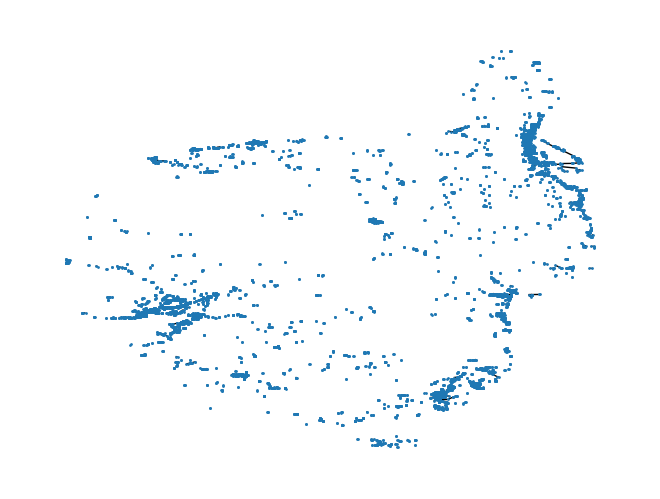

In [84]:
pos={node:(datum['x'],datum['y']) for node,datum in G_osm.nodes(data=True)}
nx.draw(G_osm,pos=pos,node_size=1)

In [85]:
print(len(G_osm.nodes()),len(G_osm.edges()),len(list(nx.connected_components(nx.Graph(G_osm)))),len(nx.cycle_basis(nx.Graph(G_osm))))

8738 7559 2169 943


In [86]:
t1=time.time()
k=0

true_osm_nodes=tuple(G_osm.nodes())
cmd="SELECT osm_begin,osm_end,osm_key,edge_coordinate,elevation,ST_asText(geometry) AS geometry FROM %s WHERE osm_begin IN %s"%(intersections_table_name,str(true_osm_nodes))
cursor.execute(cmd)
intersection=pd.DataFrame(cursor.fetchall())
intersection['geometry']=intersection['geometry'].apply(lambda pt:loads(pt))

for (osm_begin,osm_end,osm_key),df in intersection.groupby(['osm_begin','osm_end','osm_key']):
    df=df.sort_values('edge_coordinate')
    row=df.iloc[0]
    neighbor_pt,neighbor_elevation,length=row['geometry'],row['elevation'],row['edge_coordinate']
    G_osm.add_node((osm_begin,k),x=neighbor_pt.x,y=neighbor_pt.y,elevation=neighbor_elevation)
    G_osm.add_edge(osm_begin,(osm_begin,k),length=length)
    k+=1

cmd="SELECT osm_begin,osm_end,osm_key,length FROM %s WHERE osm_end IN %s"%(osm_edges_table_name,str(true_osm_nodes))
cursor.execute(cmd)
lengths={(elem['osm_begin'],elem['osm_end'],elem['osm_key']):elem['length'] for elem in cursor.fetchall()}

cmd="SELECT osm_begin,osm_end,osm_key,edge_coordinate,elevation,ST_asText(geometry) AS geometry FROM %s WHERE (osm_begin,osm_end,osm_key) IN %s"%(intersections_table_name,str(tuple(lengths.keys())))
cursor.execute(cmd)
intersection=pd.DataFrame(cursor.fetchall())
intersection['geometry']=intersection['geometry'].apply(lambda pt:loads(pt))

for (osm_begin,osm_end,osm_key),df in intersection.groupby(['osm_begin','osm_end','osm_key']):
    df=df.sort_values('edge_coordinate')
    row=df.iloc[-1]
    neighbor_pt,neighbor_elevation,length=row['geometry'],row['elevation'],lengths[(osm_begin,osm_end,osm_key)]-row['edge_coordinate']
    G_osm.add_node((osm_end,k),x=neighbor_pt.x,y=neighbor_pt.y,elevation=neighbor_elevation)
    G_osm.add_edge((osm_end,k),osm_end,length=length)
    k+=1

t2=time.time()
print(t2-t1)

4.1550750732421875


In [87]:
t1=time.time()
CC=sorted(list(nx.connected_components(nx.Graph(G_osm))),key=len)
t2=time.time()
print(t2-t1)

0.1739211082458496


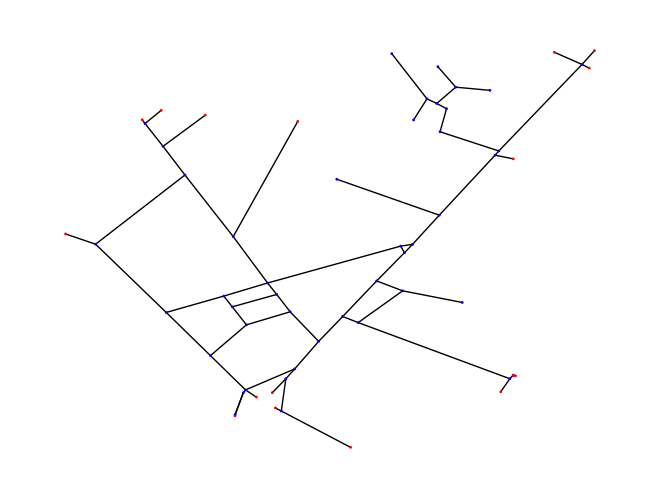

In [309]:
cc=CC[-5]
sub_G_osm=nx.subgraph(G_osm,cc)
pos={node:(datum['x'],datum['y']) for node,datum in G_osm.nodes(data=True)}
node_color=['r' if isinstance(node,tuple) else 'b' for node in sub_G_osm.nodes()]
nx.draw(sub_G_osm,pos=pos,node_color=node_color,node_size=1)

In [ ]:
def estimate_elevations_from_laplacian(sub_G_osm,verbose=False):
    nodes=list(sub_G_osm.nodes())
    variable_indexes=[k for k,node in enumerate(nodes) if not(isinstance(node,tuple))]
    constant_indexes=[k for k,node in enumerate(nodes) if isinstance(node,tuple)]
    elevations=[sub_G_osm.nodes()[nodes[k]]['elevation'] for k in constant_indexes]
    print(set(elevations))
    L=nx.laplacian_matrix(sub_G_osm,weight='length').toarray()
    A=np.array([[L[i,j] for j in variable_indexes] for i in variable_indexes])
    B=np.array([2*np.sum([L[i,constant_indexes[k]]*elevation for k,elevation in enumerate(elevations)]) for i in variable_indexes])

    K=np.linalg.norm(B)
    A/=K
    B/=K

    fun=lambda X:np.sum(X*np.matmul(A,X))+np.sum(B*X)
    x0=np.mean(elevations)*np.ones(len(variable_indexes))
    res=minimize(fun,x0)
    if verbose:
        print(res.message)
    return res.x

In [310]:
nodes=list(sub_G_osm.nodes())
variable_indexes=[k for k,node in enumerate(nodes) if not(isinstance(node,tuple))]
constant_indexes=[k for k,node in enumerate(nodes) if isinstance(node,tuple)]
elevations=[sub_G_osm.nodes()[nodes[k]]['elevation'] for k in constant_indexes]
print(set(elevations))
L=nx.laplacian_matrix(sub_G_osm,weight='length').toarray()
A=np.array([[L[i,j] for j in variable_indexes] for i in variable_indexes])
B=np.array([2*np.sum([L[i,constant_indexes[k]]*elevation for k,elevation in enumerate(elevations)]) for i in variable_indexes])
C=np.array([[L[i,j] for j in constant_indexes] for i in constant_indexes])
c=np.sum(np.array(elevations)*np.matmul(C,np.array(elevations)))

{20.0, 15.0}


In [311]:
X=10*np.random.rand(len(nodes))
for k,index in enumerate(constant_indexes):
    X[index]=elevations[k]
y1=np.sum(X*np.matmul(L,X))

X=np.array([X[k] for k in variable_indexes])
y2=np.sum(X*np.matmul(A,X))+np.sum(B*X)+c
(y2-y1)/y1

1.782511677230992e-16

In [312]:
estimated_elevations=-np.matmul(np.linalg.inv(A),B)
estimated_elevations

array([34.32113868, 32.19958911, 39.11277561, 39.11277561, 39.11277561,
       33.09501157, 39.11277561, 33.32577394, 33.59586656, 31.35586652,
       39.3762513 , 39.11277561, 33.3589611 , 31.92669783, 30.67523636,
       39.42726946, 33.48175313, 30.26601552, 38.96089828, 33.83276256,
       38.73364528, 34.46708843, 32.31330782, 39.11277561, 39.11277561,
       36.57993451, 34.58743706, 33.83276256, 39.11277561, 39.11277561,
       34.35331965, 34.13906769, 35.17432446, 35.28468407, 36.94693352,
       35.28001607, 35.50352583, 37.25778226, 35.88111068, 33.63531919,
       32.25310833, 32.59617211, 39.11277561, 32.59617211])

In [313]:
K=np.linalg.norm(B)
A/=K
B/=K

In [314]:
t1=time.time()
fun=lambda X:np.sum(X*np.matmul(A,X))+np.sum(B*X)
jac=lambda X:np.matmul(A,X)+B
hess=A
x0=np.mean(elevations)*np.ones(len(variable_indexes))
res=minimize(fun,x0)
print(res.message)
t2=time.time()
print(t2-t1)

Optimization terminated successfully.
0.22584986686706543


In [315]:
res.x-estimated_elevations

array([-17.1621995 , -16.09918112, -19.557389  , -19.55857001,
       -19.55812784, -16.54585775, -19.55798506, -16.6613376 ,
       -16.80024977, -15.67992925, -19.68883713, -19.55682638,
       -16.67858836, -15.96277163, -15.33751821, -19.71360797,
       -16.74019494, -15.13301104, -19.48048007, -16.91892733,
       -19.36657162, -17.23206409, -16.15818783, -19.55652468,
       -19.55787749, -18.28948222, -17.29163387, -16.91927653,
       -19.5579833 , -19.55726404, -17.17460474, -17.06935772,
       -17.58482022, -17.64017927, -18.47281534, -17.63903393,
       -17.7511848 , -18.62852692, -17.93940856, -16.81619497,
       -16.128635  , -16.29764275, -19.55866648, -16.29761616])

In [316]:
res.x

array([17.15893918, 16.10040799, 19.55538661, 19.5542056 , 19.55464778,
       16.54915382, 19.55479055, 16.66443634, 16.79561679, 15.67593726,
       19.68741417, 19.55594924, 16.68037274, 15.9639262 , 15.33771815,
       19.71366149, 16.74155819, 15.13300448, 19.48041821, 16.91383523,
       19.36707366, 17.23502434, 16.15511998, 19.55625094, 19.55489812,
       18.29045229, 17.2958032 , 16.91348603, 19.55479231, 19.55551158,
       17.17871491, 17.06970997, 17.58950424, 17.64450479, 18.47411818,
       17.64098214, 17.75234104, 18.62925534, 17.94170212, 16.81912422,
       16.12447334, 16.29852936, 19.55410913, 16.29855596])